Projekat iz predmeta Soft Kompjuting 

Photo Calculator

In [2]:
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.spatial import distance

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno


In [3]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

In [5]:
def select_roi(image_orig, image_bin):
    
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,h,w = cv2.boundingRect(contour)

        region_points = []
        for i in range (xt,xt+h):
            for j in range(yt,yt+w):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
        contour_centers.append(center)
        contour_angles.append(angle)
        contour_sizes.append(size)
        contours.append(region_points)
    
    #Postavljanje kontura u vertikalan polozaj
    contours = rotate_regions(contours, contour_angles, contour_centers, contour_sizes)
    
    #spajanje kukica i kvacica
    contours = merge_regions(contours)
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])

        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
             # TODO 3 - koordinate tacaka regiona prebaciti u relativne koordinate
            '''Pretpostavimo da gornja leva tačka regiona ima apsolutne koordinate (100,100).
            Ako uzmemo tačku sa koordinatama unutar regiona, recimo (105,105), nakon
            prebacivanja u relativne koordinate tačka bi trebala imati koorinate (5,5) unutar
            samog regiona.
            '''
            region[y-min_y,x-min_x] = 255

        
        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    return image_orig, sorted_regions[:, 0], region_distances

In [9]:
def create_ann():
    
    ann = Sequential()
    # Postavljanje slojeva neurona mreže 'ann'
    ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    ann.add(Dense(input_dim=128, output_dim=27,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

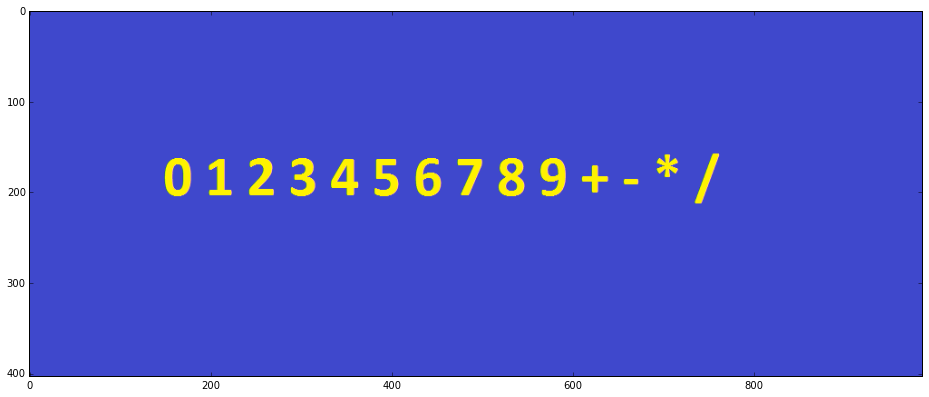

In [4]:
train_image_color = load_image('images/train_osnovno.png')
display_image(train_image_color)

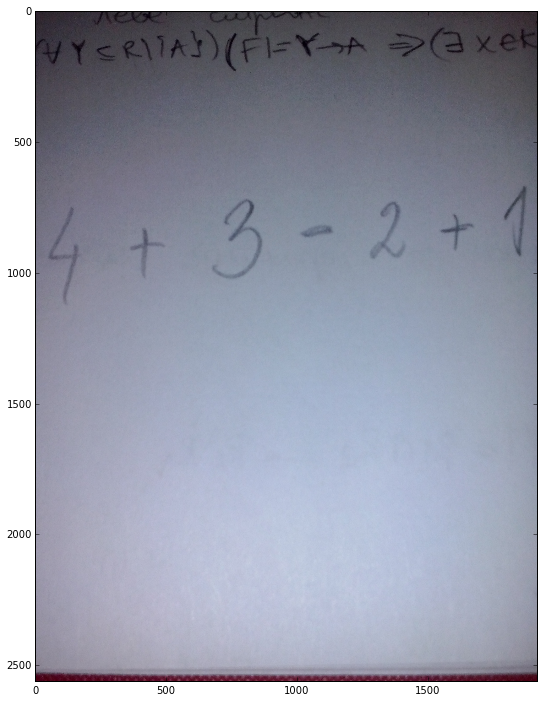

In [11]:
test_image_color = load_image('images/slika2.jpg')
display_image(test_image_color)